In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

C:\Users\Irfan\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow version:", keras.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.10.0
NumPy version: 1.26.0


In [3]:
gRNA_LENGTH = 28
input_length = 33

In [4]:
dct_ohc_seq = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1],
               'N': [0, 0, 0, 0]}

def seq_one_hot_code(seq):
    seq = seq.upper()
    lst_seq = list(seq)
    return [dct_ohc_seq[i] for i in lst_seq]

In [5]:
file = 'BS6204_input.10WINDOW.csv'
WINDOW_LENGTH_ORIGINAL=10
LENGTH_TO_TEST=3
INPUT_LENGTH=LENGTH_TO_TEST + gRNA_LENGTH + LENGTH_TO_TEST
ACTUAL_LENGTH = WINDOW_LENGTH_ORIGINAL + gRNA_LENGTH + WINDOW_LENGTH_ORIGINAL

class inputObject:
    
    def __init__(self, col):
        self.seq_id = col[0]
        assert len(col[1]) == ACTUAL_LENGTH
        self.seq = col[1][WINDOW_LENGTH_ORIGINAL-LENGTH_TO_TEST:WINDOW_LENGTH_ORIGINAL+gRNA_LENGTH+LENGTH_TO_TEST]
        #self.quartile = int(col[2].replace('Q',''))
        #self.guideScore = float(col[3])
        self.quartile = None
        self.guideScore = None

seq_dict = {}
with open(file, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split(',')
        seq_id = col[0]
        seq_dict[seq_id] = inputObject(col)

# Update Using Mean-Normalized Score2
file2 = "MeanAdjustedScores.csv"
with open(file2, 'r') as f:
    next(f)
    for line in f:
        col = [i.replace('"','').replace('"','') for i in line.strip('\n').split(',')]
        seq_id = col[0] 
        seq_dict[seq_id].quartile = int(col[11].replace('Q',''))
        seq_dict[seq_id].guideScore = float(col[10])

In [6]:
seq   = []
score = []
quart = []

for k,v in seq_dict.items():
    seq.append(v.seq)
    score.append(v.guideScore)
    quart.append(v.quartile-1)
    
target_data = np.array(score)
quart_data  = np.array(quart)
    
nt_dict = {'A':1, 'C':2, 'G':3, 'T':4, 'N':0}    

# X_train_seq = [seq_one_hot_code(s) for s in seq]
X_train_seq = [[nt_dict[s] for s in s1] for s1 in seq]
X_train_arr_seq = np.array(X_train_seq)

quart = [0 if i<2 else 1 for i in quart]
quart_data = np.array(quart)
num_classes = 2
one_hot_labels = to_categorical(quart_data, num_classes)

In [7]:
print(quart.count(0), quart.count(1))

225 225


In [8]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, TimeDistributed, Flatten, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import concatenate
from keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Reshape

# Sequential model for sequence input
seq_model = Sequential()
seq_model.add(Reshape((INPUT_LENGTH, 1), input_shape=(INPUT_LENGTH,)))  # Reshape input

# Add a Bidirectional LSTM layer
seq_model.add(Bidirectional(LSTM(units=INPUT_LENGTH, return_sequences=True, activation='relu'))) # You can adjust the number of units as needed
seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(32, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Flatten())


NN_output  = Dense(2, activation='softmax')(seq_model.output)

# Create the final model
NN_model = Model(inputs=[seq_model.input], outputs=NN_output)


In [9]:
NN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, 34)]              0         
                                                                 
 reshape (Reshape)           (None, 34, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 34, 68)           9792      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 68)            0         
                                                                 
 dense (Dense)               (None, 34, 64)            4416      
                                                                 
 dropout_1 (Dropout)         (None, 34, 64)            0         
                                                             

Code for Model Training

In [10]:
from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

In [11]:
def custom_true_positive_metric(y_true, y_pred):
    # Calculate True Positives (TP)
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    
    # Return True Positives as the custom metric
    return true_positives

def custom_loss(y_true, y_pred):
    # Weight for False Negatives (increase this value to prioritize TP)
    weight_fn = 10  # You can adjust this value as needed

    # Ensure y_true and y_pred are compatible for binary classification
    y_true = tf.cast(y_true, tf.float32)

    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Calculate the number of False Negatives (FN)
    fn = tf.reduce_sum(tf.maximum(y_true - y_pred, 0))

    # Modify the loss by applying the weight to FN
    custom_loss = bce + weight_fn * fn

    return custom_loss

In [12]:
# let's define more parameters
# yinning.huang@gmail.com
batch_size = 128
num_epochs = 120

from keras.optimizers import SGD, Adam  # or any other optimizer you are using

# Define your optimizer with a custom learning rate
custom_lr = 0.0025  # Change this value to the desired learning rate 
custom_optimizer = Adam(learning_rate=custom_lr)


NN_model.compile(loss      = custom_loss, # binary_crossentropy,
                 optimizer = custom_optimizer,
                 metrics   = [custom_true_positive_metric, "accuracy"]) # ["accuracy"]

In [13]:
#X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH, 4, 1)) 
X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH)) 

In [14]:
history = NN_model.fit([X_train_seq_CNN], one_hot_labels, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2)

Epoch 1/120
3/3 [==============================] - 3s 250ms/step - loss: 607.5998 - custom_true_positive_metric: 58.0000 - accuracy: 0.4833 - val_loss: 454.7787 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 2/120
3/3 [==============================] - 0s 53ms/step - loss: 602.6924 - custom_true_positive_metric: 61.3333 - accuracy: 0.5111 - val_loss: 461.5216 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 3/120
3/3 [==============================] - 0s 44ms/step - loss: 606.0557 - custom_true_positive_metric: 62.3333 - accuracy: 0.5194 - val_loss: 474.0696 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 4/120
3/3 [==============================] - 0s 43ms/step - loss: 593.4147 - custom_true_positive_metric: 61.6667 - accuracy: 0.5139 - val_loss: 483.5406 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 5/120
3/3 [==============================] - 0s 44ms/step - loss: 587.3494 - custom_true_

3/3 [==============================] - 0s 37ms/step - loss: 495.6739 - custom_true_positive_metric: 70.6667 - accuracy: 0.5889 - val_loss: 489.7534 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 74/120
3/3 [==============================] - 0s 37ms/step - loss: 528.8857 - custom_true_positive_metric: 69.3333 - accuracy: 0.5778 - val_loss: 483.1613 - val_custom_true_positive_metric: 41.0000 - val_accuracy: 0.4556
Epoch 75/120
3/3 [==============================] - 0s 39ms/step - loss: 509.9257 - custom_true_positive_metric: 68.6667 - accuracy: 0.5722 - val_loss: 484.4427 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 76/120
3/3 [==============================] - 0s 37ms/step - loss: 528.6959 - custom_true_positive_metric: 68.0000 - accuracy: 0.5667 - val_loss: 491.5382 - val_custom_true_positive_metric: 38.0000 - val_accuracy: 0.4222
Epoch 77/120
3/3 [==============================] - 0s 37ms/step - loss: 523.8922 - custom_true_positive_

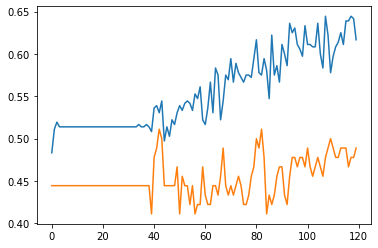

In [15]:
# plot accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

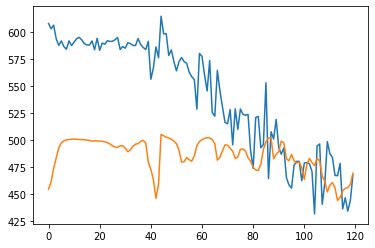

In [16]:
# plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [17]:
predicted_values_for_X_train = NN_model.predict([X_train_seq_CNN])
predicted_values_for_X_train

15/15 [==============================] - 0s 6ms/step


array([[9.99999881e-01, 1.38581100e-07],
       [9.99904037e-01, 9.59807076e-05],
       [6.41391933e-01, 3.58608067e-01],
       [1.37903466e-04, 9.99862075e-01],
       [1.16605752e-05, 9.99988317e-01],
       [2.74942582e-03, 9.97250617e-01],
       [9.08800925e-04, 9.99091148e-01],
       [7.17703283e-01, 2.82296687e-01],
       [5.81653342e-02, 9.41834688e-01],
       [9.99261081e-01, 7.38934381e-04],
       [9.99987125e-01, 1.29229165e-05],
       [7.27952982e-04, 9.99272048e-01],
       [7.04742634e-13, 1.00000000e+00],
       [3.17673028e-01, 6.82327032e-01],
       [1.17791665e-03, 9.98822033e-01],
       [9.86316264e-01, 1.36837224e-02],
       [9.99965668e-01, 3.43128340e-05],
       [7.73383141e-01, 2.26616845e-01],
       [1.95055585e-02, 9.80494380e-01],
       [9.96313870e-01, 3.68615240e-03],
       [3.36795184e-03, 9.96632040e-01],
       [9.87440467e-01, 1.25594828e-02],
       [9.99999881e-01, 1.07433834e-07],
       [9.94109750e-01, 5.89026138e-03],
       [2.016117

In [18]:
predicted_labels = np.argmax(predicted_values_for_X_train, axis=1)
poor_count = 0
for c, (i,j) in enumerate(zip(predicted_labels, quart_data)):
    poor = 'Poor' if i == 1 and j == 0 else 'Okay'
    if poor == 'Poor':
        poor_count += 1
    print (c, "Pred", i, "True", j, i==j, poor)

0 Pred 0 True 0 True Okay
1 Pred 0 True 0 True Okay
2 Pred 0 True 0 True Okay
3 Pred 1 True 0 False Poor
4 Pred 1 True 0 False Poor
5 Pred 1 True 0 False Poor
6 Pred 1 True 0 False Poor
7 Pred 0 True 0 True Okay
8 Pred 1 True 0 False Poor
9 Pred 0 True 1 False Okay
10 Pred 0 True 0 True Okay
11 Pred 1 True 0 False Poor
12 Pred 1 True 0 False Poor
13 Pred 1 True 0 False Poor
14 Pred 1 True 1 True Okay
15 Pred 0 True 1 False Okay
16 Pred 0 True 0 True Okay
17 Pred 0 True 1 False Okay
18 Pred 1 True 0 False Poor
19 Pred 0 True 1 False Okay
20 Pred 1 True 1 True Okay
21 Pred 0 True 0 True Okay
22 Pred 0 True 0 True Okay
23 Pred 0 True 1 False Okay
24 Pred 1 True 0 False Poor
25 Pred 0 True 1 False Okay
26 Pred 0 True 1 False Okay
27 Pred 1 True 1 True Okay
28 Pred 1 True 1 True Okay
29 Pred 1 True 0 False Poor
30 Pred 0 True 1 False Okay
31 Pred 1 True 1 True Okay
32 Pred 1 True 1 True Okay
33 Pred 1 True 0 False Poor
34 Pred 1 True 1 True Okay
35 Pred 0 True 0 True Okay
36 Pred 1 True 1 T

315 Pred 1 True 1 True Okay
316 Pred 1 True 1 True Okay
317 Pred 0 True 0 True Okay
318 Pred 1 True 0 False Poor
319 Pred 0 True 0 True Okay
320 Pred 0 True 0 True Okay
321 Pred 1 True 0 False Poor
322 Pred 1 True 1 True Okay
323 Pred 1 True 0 False Poor
324 Pred 1 True 1 True Okay
325 Pred 0 True 0 True Okay
326 Pred 0 True 0 True Okay
327 Pred 1 True 0 False Poor
328 Pred 0 True 0 True Okay
329 Pred 1 True 0 False Poor
330 Pred 1 True 1 True Okay
331 Pred 0 True 1 False Okay
332 Pred 1 True 0 False Poor
333 Pred 0 True 0 True Okay
334 Pred 1 True 1 True Okay
335 Pred 1 True 1 True Okay
336 Pred 1 True 1 True Okay
337 Pred 1 True 0 False Poor
338 Pred 0 True 0 True Okay
339 Pred 0 True 0 True Okay
340 Pred 0 True 0 True Okay
341 Pred 0 True 0 True Okay
342 Pred 1 True 1 True Okay
343 Pred 0 True 0 True Okay
344 Pred 1 True 1 True Okay
345 Pred 1 True 1 True Okay
346 Pred 1 True 1 True Okay
347 Pred 1 True 1 True Okay
348 Pred 1 True 1 True Okay
349 Pred 0 True 1 False Okay
350 Pred 1 

In [19]:
print (poor_count, len(quart_data))

106 450


In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(quart_data,predicted_labels)
cm

array([[119, 106],
       [ 63, 162]], dtype=int64)